## SETUP

In [ ]:
!pip install dezerogym

## ch05/dice.py

In [1]:
import numpy as np


def sample(dices=2):
    x = 0
    for _ in range(dices):
        x += np.random.choice([1, 2, 3, 4, 5, 6])
    return x


trial = 1000
V, n = 0, 0

for _ in range(trial):
    s = sample()
    n += 1
    V += (s - V) / n
    print(V)

3.0
4.0
5.333333333333333
5.75
5.8
5.833333333333333
5.285714285714286
5.875
6.111111111111111
6.3
6.0
6.416666666666667
6.538461538461538
6.642857142857142
6.7333333333333325
6.874999999999999
6.941176470588235
6.722222222222221
6.473684210526315
6.6499999999999995
6.666666666666666
6.681818181818182
6.608695652173913
6.75
6.72
6.9230769230769225
6.925925925925926
7.107142857142857
7.1724137931034475
7.0666666666666655
6.903225806451612
6.999999999999999
7.06060606060606
7.088235294117646
7.17142857142857
7.194444444444443
7.1621621621621605
7.052631578947366
6.999999999999998
6.999999999999998
7.1219512195121935
7.071428571428569
7.023255813953487
7.068181818181817
6.955555555555554
7.065217391304346
6.999999999999998
6.916666666666665
6.857142857142856
6.839999999999999
6.784313725490195
6.807692307692307
6.792452830188678
6.777777777777776
6.745454545454543
6.732142857142855
6.789473684210524
6.793103448275859
6.745762711864404
6.666666666666663
6.672131147540981
6.7258064516129
6.

## ch05/mc_eval.py

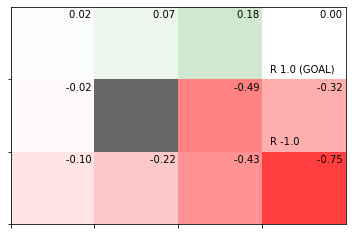

In [2]:
from collections import defaultdict
import numpy as np
from dezerogym.gridworld import GridWorld


class RandomAgent:
    def __init__(self):
        self.gamma = 0.9
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)
        self.cnts = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def eval(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]


env = GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.eval()
            break

        state = next_state

env.render_v(agent.V)

## ch05/mc_control.py

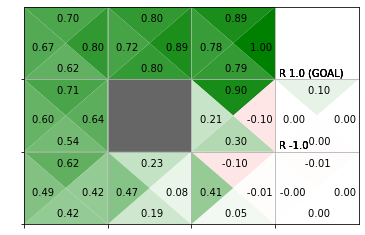

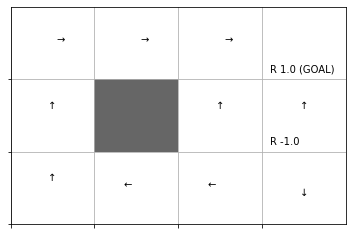

In [3]:
def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = np.argmax(qs)

    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs


class McAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.Q[key] += (G - self.Q[key]) * self.alpha
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)


env = GridWorld()
agent = McAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)

## ch05/importance_sampling.py

In [4]:
x = np.array([1, 2, 3])
pi = np.array([0.1, 0.1, 0.8])

# =========== Expectation ==================
e = np.sum(x * pi)
print('E_pi[x]', e)

# =========== Monte Carlo ==================
n = 100
samples = []
for _ in range(n):
    s = np.random.choice(x, p=pi)
    samples.append(s)
print('MC: {:.2f} (var: {:.2f})'.format(np.mean(samples), np.var(samples)))

# =========== Importance Sampling ===========
b = np.array([0.2, 0.2, 0.6])  #b = np.array([1/3, 1/3, 1/3])
samples = []
for _ in range(n):
    idx = np.arange(len(b))  # [0, 1, 2]
    i = np.random.choice(idx, p=b)
    s = x[i]
    rho = pi[i] / b[i]
    samples.append(rho * s)
print('IS: {:.2f} (var: {:.2f})'.format(np.mean(samples), np.var(samples)))

E_pi[x] 2.7
MC: 2.77 (var: 0.34)
IS: 2.78 (var: 2.56)


## ch05/mc_control_offpolicy.py

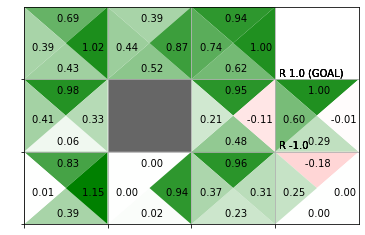

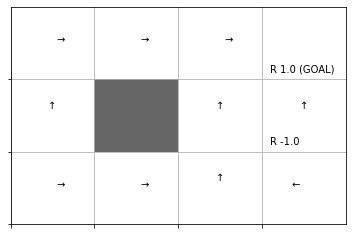

In [5]:
class McOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.epsilon = 0.1
        self.alpha = 0.2
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = []

    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)

    def reset(self):
        self.memory.clear()

    def update(self):
        G = 0
        rho = 1

        for data in reversed(self.memory):
            state, action, reward = data
            key = (state, action)

            G = self.gamma * rho * G + reward
            self.Q[key] += (G - self.Q[key]) * self.alpha
            rho *= self.pi[state][action] / self.b[state][action]

            self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
            self.b[state] = greedy_probs(self.Q, state, self.epsilon)


env = GridWorld()
agent = McOffPolicyAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break

        state = next_state

env.render_q(agent.Q)